In [1]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *
from sklearn.mixture import BayesianGaussianMixture
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

from sklearn.metrics import adjusted_mutual_info_score

2024-07-22 16:14:32.305476: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import os
import scipy.io

In [3]:
# Load dataset from file
folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'

# List all .mat files in the folder and load them
cnc_maps = scipy.io.loadmat(folder_path + 'cncMaps.mat')['cncMaps']
esc_maps = scipy.io.loadmat(folder_path + 'escMaps.mat')['escMaps']


In [14]:
# Count the number of NaN values in the dataset
cnc_nan_count = np.sum(np.isnan(cnc_maps), axis=2) / cnc_maps.shape[2]

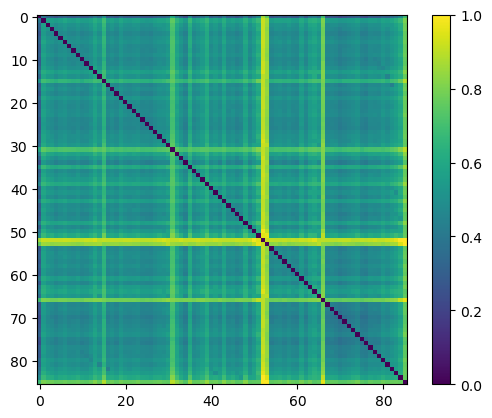

In [20]:
plt.imshow(cnc_nan_count)
plt.colorbar()

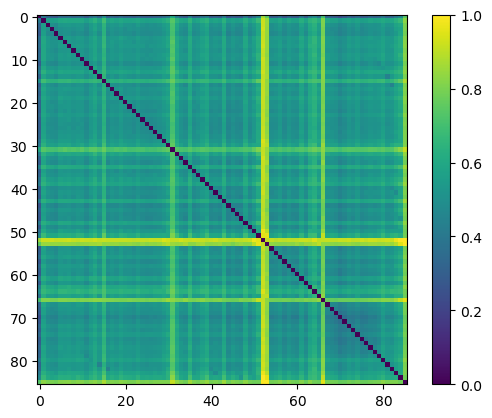

In [21]:
esc_nan_count = np.sum(np.isnan(esc_maps), axis=2) / esc_maps.shape[2]
plt.imshow(esc_nan_count)
plt.colorbar()

In [4]:
esc_maps_flat = np.array([esc_maps[:, :, i].flatten() for i in range(esc_maps.shape[2])])

In [4]:
# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols']
esc_polys = scipy.io.loadmat(folder_path + 'escPols.amat')['escPols']

In [5]:
def interpolate_polymers(polys):
    num_probes, num_coords, num_cells = polys.shape
    new_polys = np.zeros((num_probes, num_coords, num_cells))
    for c in range(num_cells):
        curr_cells = polys[:, :, c]
        for x in range(num_coords):
            curr_coords = curr_cells[:, x]
            missing_indices = np.isnan(curr_coords)
            valid_indices = ~missing_indices
            interp_coords = np.interp(np.flatnonzero(missing_indices), np.flatnonzero(valid_indices), curr_coords[valid_indices])
            new_polys[missing_indices, x, c] = interp_coords
            new_polys[valid_indices, x, c] = curr_coords[valid_indices]
    return new_polys

In [36]:
esc_polys_interp = interpolate_polymers(esc_polys)

In [37]:
esc_maps_interp = [squareform(pdist(esc_polys_interp[:, :, i])) for i in range(esc_polys_interp.shape[2])]

In [52]:
cnc_polys_interp = interpolate_polymers(cnc_polys)
cnc_maps_interp = [squareform(pdist(cnc_polys_interp[:, :, i])) for i in range(cnc_polys_interp.shape[2])]

In [38]:
esc_maps_interp = np.array(esc_maps_interp)

In [39]:
np.median(esc_maps_interp, axis=0).shape

(86, 86)

In [40]:
esc_maps_interp[0, :, :]

array([[   0.        ,  162.50719646,  325.01439293, ...,  494.52780097,
        1273.70091141, 1273.70091141],
       [ 162.50719646,    0.        ,  162.50719646, ...,  436.87278753,
        1280.94186656, 1280.94186656],
       [ 325.01439293,  162.50719646,    0.        , ...,  435.86132753,
        1308.48282261, 1308.48282261],
       ...,
       [ 494.52780097,  436.87278753,  435.86132753, ...,    0.        ,
         980.7603007 ,  980.7603007 ],
       [1273.70091141, 1280.94186656, 1308.48282261, ...,  980.7603007 ,
           0.        ,    0.        ],
       [1273.70091141, 1280.94186656, 1308.48282261, ...,  980.7603007 ,
           0.        ,    0.        ]])

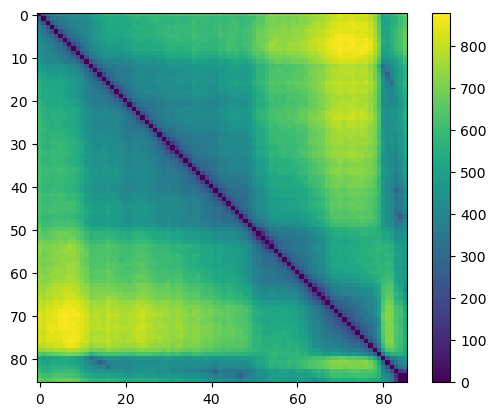

In [41]:
plt.imshow(np.median(esc_maps_interp, axis=0))
plt.colorbar()

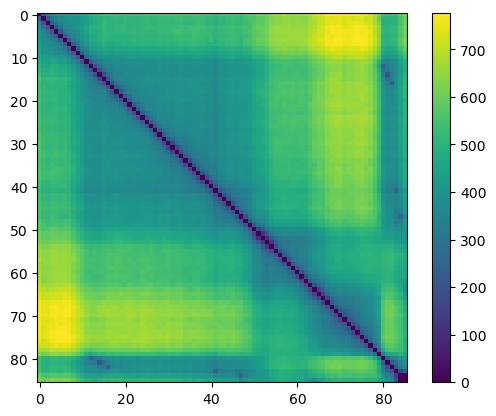

In [53]:
plt.imshow(np.median(cnc_maps_interp, axis=0))
plt.colorbar()

In [62]:
n_comp = 10

# Create and fit the Bayesian Gaussian Mixture Model
bgmm = BayesianGaussianMixture(
    n_components=n_comp,      # Maximum number of components
    covariance_type='full', # Type of covariance parameters
    max_iter=1000,         # Maximum number of iterations  
    verbose=2
)

In [63]:
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
bgmm.fit(esc_maps_interp_flat)

Initialization 0
Initialization converged: True	 time lapse 98.43165s	 ll 2779470612.09602


BayesianGaussianMixture(max_iter=1000, n_components=10, verbose=2)

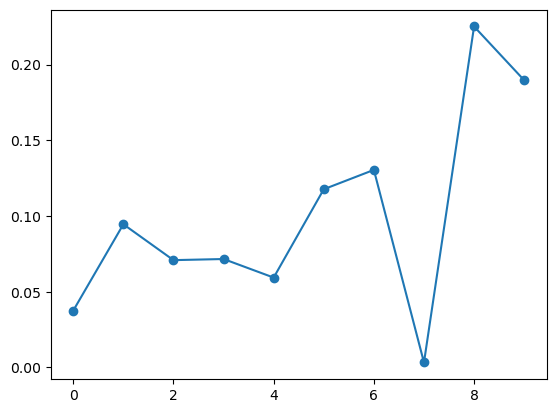

In [64]:
plt.plot(bgmm.weights_, marker='o')

In [66]:
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
# Create and fit the Bayesian Gaussian Mixture Model
bgmm_cnc = BayesianGaussianMixture(
    n_components=n_comp,      # Maximum number of components
    covariance_type='full', # Type of covariance parameters
    max_iter=1000,         # Maximum number of iterations  
    verbose=2
)
bgmm_cnc.fit(cnc_maps_interp_flat)

Initialization 0
Initialization converged: True	 time lapse 103.79022s	 ll 2275201807.14927


BayesianGaussianMixture(max_iter=1000, n_components=10, verbose=2)

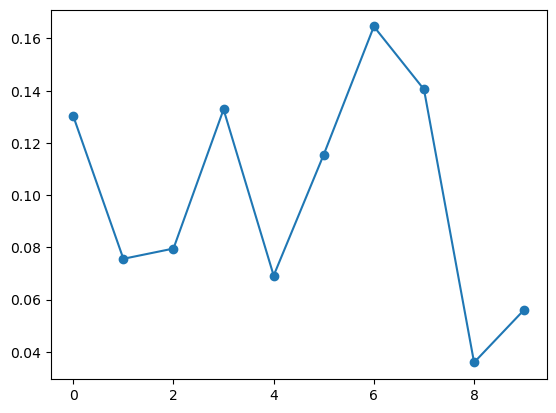

In [67]:
plt.plot(bgmm_cnc.weights_, marker='o')

In [68]:
all_maps_interp_flat = np.concatenate([esc_maps_interp_flat, cnc_maps_interp_flat], axis=0)

In [1]:
bgmm_all = BayesianGaussianMixture(
    n_components=100,      # Maximum number of components
    covariance_type='full', # Type of covariance parameters
    max_iter=1000,         # Maximum number of iterations  
    verbose=2
)

bgmm_all.fit(all_maps_interp_flat)

NameError: name 'BayesianGaussianMixture' is not defined

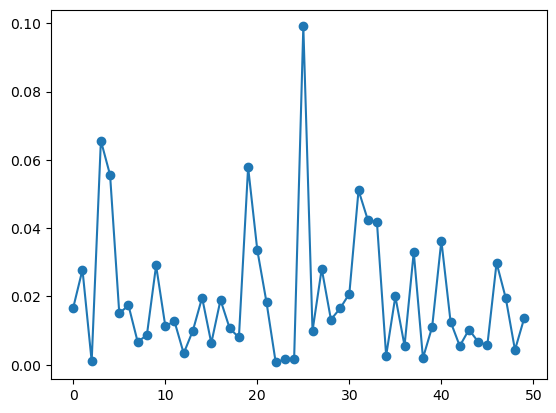

In [70]:
plt.plot(bgmm_all.weights_, marker='o')